## Setup

Context: 2021-06-16. Elliott created this notebook as a brain dump for us to replicate/create feeds.


In [ ]:
from google.cloud import bigquery

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
project_id = 'data-prod-165221'
!gcloud config set project {project_id}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey



In [ ]:
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

In [ ]:
!mkdir tmp

Fetch Cultural Relevance Data

This query computes geo/cultural relevancy scores of subreddits based on screenviews, consume events, view events, and consume/view ratios.

In [ ]:
import datetime
client = bigquery.Client(project='data-prod-165221')

cultural_relevance_data = client.query('''
    WITH
    post_consumes AS (
      SELECT
        subreddit_name,
        geo_country_code,
        COUNT(*) AS ct
      FROM (
        SELECT
          user_id,
          post_id,
          subreddit_name,
          geo_country_code
        FROM `data-prod-165221.events_v2.sample` -- change to events_v2.analytics for more data
        WHERE pt = TIMESTAMP_TRUNC(TIMESTAMP_SUB(CURRENT_TIMESTAMP, INTERVAL 2 DAY), DAY)
          AND geo_country_code IN ('AT','IT', 'CA', 'GB', 'DE', 'FR', 'ES')
          AND subreddit_name IS NOT NULL
          AND source = 'post'
          AND action = 'consume'
          AND noun = 'post'
          AND action_info_page_type IN ('community', 'home', 'popular')
          AND subreddit_name IS NOT NULL
        GROUP BY
          user_id,
          post_id,
          subreddit_name,
          geo_country_code
      )
      GROUP BY
        subreddit_name,
        geo_country_code
    ),

    post_views AS (
      SELECT
        subreddit_name,
        geo_country_code,
        COUNT(*) AS ct
      FROM (
        SELECT
          user_id,
          post_id,
          subreddit_name,
          geo_country_code
        FROM `data-prod-165221.events_v2.sample` -- change to events_v2.analytics for more data
        WHERE pt = TIMESTAMP_TRUNC(TIMESTAMP_SUB(CURRENT_TIMESTAMP, INTERVAL 2 DAY), DAY)
          AND geo_country_code IN ('AT','IT', 'CA', 'GB', 'DE', 'FR', 'ES')
          AND subreddit_name IS NOT NULL
          AND source = 'post'
          AND action = 'view'
          AND noun = 'post'
          AND action_info_page_type IN ('community', 'home', 'popular')
          AND subreddit_name IS NOT NULL
        GROUP BY
          user_id,
          post_id,
          subreddit_name,
          geo_country_code
      )
      GROUP BY
        subreddit_name,
        geo_country_code
    ),
    
    post_screenviews AS (
      SELECT
        subreddit_name,
        geo_country_code,
        COUNT(*) AS ct
      FROM (
        SELECT
          user_id,
          post_id,
          subreddit_name,
          geo_country_code
        FROM `data-prod-165221.fact_tables.screenview_events`
        WHERE pt = TIMESTAMP_TRUNC(TIMESTAMP_SUB(CURRENT_TIMESTAMP, INTERVAL 2 DAY), DAY)
          AND geo_country_code IN ('AT','IT', 'CA', 'GB', 'DE', 'FR', 'ES')
          AND action_info_page_type IN ('post_detail', 'community')
          AND subreddit_name IS NOT NULL
        GROUP BY
          user_id,
          post_id,
          subreddit_name,
          geo_country_code
      )
      GROUP BY
        subreddit_name,
        geo_country_code
    ),
    
    consume_sums AS (
      SELECT
        geo_country_code,
        SUM(ct) AS sum
      FROM post_consumes
      GROUP BY geo_country_code
    ),
    
    view_sums AS (
      SELECT
        geo_country_code,
        SUM(ct) AS sum
      FROM post_views
      GROUP BY geo_country_code
    ),
    
    screenview_sums AS (
      SELECT
        geo_country_code,
        SUM(ct) AS sum
      FROM post_screenviews
      GROUP BY geo_country_code
    )

  SELECT
    geo_country_code,
    rank,
    subreddit_name,
    consumes,
    views,
    screenviews,
    consume_sum,
    view_sum,
    screenview_sum,
    consume_prob,
    view_prob,
    screenview_prob,
    consume_view_ratio
  FROM (
    SELECT
      post_consumes.subreddit_name AS subreddit_name,
      post_consumes.geo_country_code AS geo_country_code,
      post_consumes.ct AS consumes,
      post_views.ct AS views,
      post_screenviews.ct AS screenviews,
      consume_sums.sum AS consume_sum,
      view_sums.sum AS view_sum,
      screenview_sums.sum AS screenview_sum,
      (post_consumes.ct/consume_sums.sum) AS consume_prob,
      (post_views.ct/view_sums.sum) AS view_prob,
      (post_screenviews.ct/screenview_sums.sum) AS screenview_prob,
      (post_consumes.ct/post_views.ct) AS consume_view_ratio,
      ROW_NUMBER() OVER(PARTITION BY post_consumes.geo_country_code ORDER BY post_screenviews.ct DESC) AS rank
    FROM post_consumes
    JOIN post_views ON post_consumes.subreddit_name = post_views.subreddit_name
      AND post_consumes.geo_country_code = post_views.geo_country_code
    JOIN post_screenviews ON post_consumes.subreddit_name = post_screenviews.subreddit_name
      AND post_consumes.geo_country_code = post_screenviews.geo_country_code
    JOIN consume_sums ON post_consumes.geo_country_code = consume_sums.geo_country_code
    JOIN view_sums ON post_consumes.geo_country_code = view_sums.geo_country_code
    JOIN screenview_sums ON post_consumes.geo_country_code = screenview_sums.geo_country_code
    ORDER BY screenviews DESC
  )
  WHERE rank < 25
  ORDER BY geo_country_code, rank
''').result()



In [ ]:
cr_data = [row for row in cultural_relevance_data]

Compute cultural relevance probabilities for screenviews.

This can just as easily be done for post views, post consumes, or post consume/view ratios

In [ ]:

"""
  Renormalize the probability data based on the number of subs returned.
"""

from collections import defaultdict

geo_sums = defaultdict(lambda: 0)
renormalized_sr_probs = defaultdict(lambda: defaultdict(lambda: 0))

for row in cr_data:
  geo_sums[row.geo_country_code] += float(row.screenview_prob)

for row in cr_data:
  renormalized_sr_probs[row.geo_country_code][row.subreddit_name] = row.screenview_prob/geo_sums[row.geo_country_code]

for geo, data in renormalized_sr_probs.items():
  print(geo)
  for subreddit, prob in sorted(data.items(), key=lambda x: x[1], reverse=True):
    print('\t{}: {}'.format(subreddit, prob))
  print()

AT
	austria: 0.17202621993585385
	soccer: 0.10408668861018903
	askreddit: 0.08517619151220815
	memes: 0.07111525963772136
	amitheasshole: 0.05379789033385503
	leagueoflegends: 0.0522749443808909
	superstonk: 0.03998961308750975
	wien: 0.03528392063837404
	livestreamfail: 0.031662537635012325
	cryptocurrency: 0.031101082905808958
	de: 0.02886930035722558
	funny: 0.02874648213521234
	wallstreetbets: 0.02569006295311152
	games: 0.0247355899134658
	europe: 0.023749535045302386
	relationship_advice: 0.02353898952185112
	publicfreakout: 0.023510916785390953
	nextfuckinglevel: 0.022282734565258592
	aww: 0.021717770743997705
	interestingasfuck: 0.021524770680834047
	ich_iel: 0.020977352319860764
	dankmemes: 0.019987788359639835
	cringetopia: 0.019756188283843446
	worldnews: 0.018398169657582803

CA
	askreddit: 0.12216876892242105
	amitheasshole: 0.08832256357900867
	nba: 0.056096548932954245
	superstonk: 0.05600634513104875
	ontario: 0.04356104612935487
	mma: 0.04097578343088749
	vancouver: 0.

DE cultural relevance subreddit scores based on screenviews

In [ ]:
de_cultural_relevance_scores = { # remove the hentai sub
  'de': 0.1481912387650051,
	'askreddit': 0.08340504524566232,
	'memes': 0.08070345912328367,
	'soccer': 0.06814823940693863,
	'ich_iel': 0.06488947719931713,
	'leagueoflegends': 0.06274506716218131,
	'amitheasshole': 0.05404885920164958,
	'superstonk': 0.053218884517730054,
	'livestreamfail': 0.0387661166540534,
	'wallstreetbets': 0.033450943957256306,
	'funny': 0.028462295898943172,
	'games': 0.025543026684241875,
	'relationship_advice': 0.023226785950825855,
	'cryptocurrency': 0.023121649648789173,
	'publicfreakout': 0.023081355118933708,
	'genshin_impact': 0.022099928581419497,
	'nextfuckinglevel': 0.02143483726104649,
	'finanzen': 0.021359342912006935,
	'interestingasfuck': 0.021131007242825954,
	'aww': 0.020818377269809393,
	'cringetopia': 0.02070166207988321,
	'europe': 0.020599767866455593,
	'dankmemes': 0.020394589973053615
}

Visualize the mighty geo data

In [ ]:
DE_SV = ['{},{}\n'.format(sub, score) for sub, score in de_cultural_relevance_scores.items()]

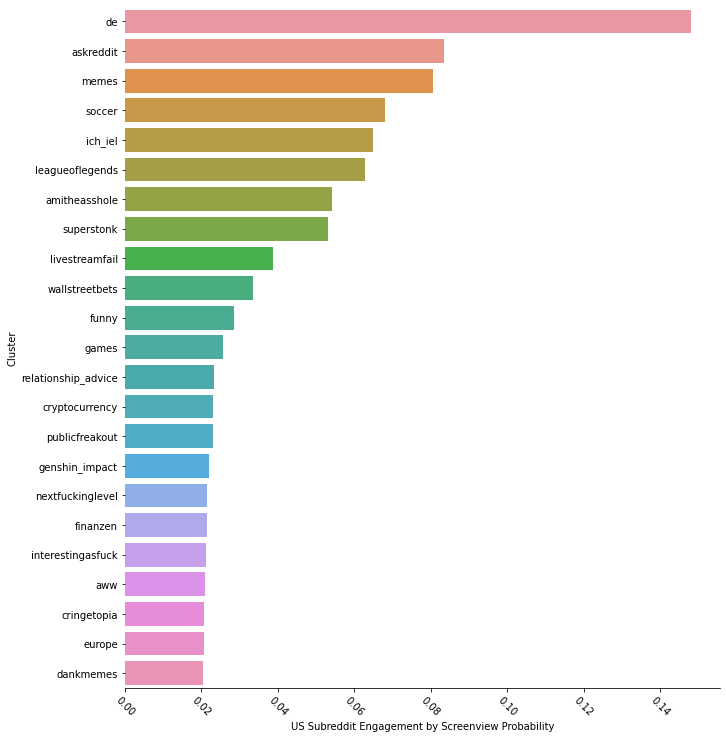

In [ ]:
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sub_geo_csv = 'subreddit,geo_score\n' + '\n'.join(DE_SV)
from io import StringIO
sub_geo_df = pd.read_csv(StringIO(sub_geo_csv))
g = sns.catplot(x="geo_score", y="subreddit", data=sub_geo_df,
                height=10,aspect=1, kind="bar", orient='h')
g.despine(left=True)
plt.xticks(rotation=-45)
# g.despine(left=True, bottom=True)
g.set_ylabels("Cluster")
g.set_xlabels("US Subreddit Engagement by Screenview Probability")
g.savefig("tmp/i18n_us_sv.png")

Fetch the regular popular listing

In [ ]:
popular_hot_data = client.query('''
  WITH
    post_votes AS (
      SELECT
        post_id,
        LOWER(subreddit_name) AS subreddit_name,
        post_created_timestamp,
        MAX(post_score) AS vote_score,
      FROM `data-prod-165221.events_v2.analytics`
      WHERE
        pt <= TIMESTAMP_TRUNC(CURRENT_TIMESTAMP, DAY)
        AND pt >= TIMESTAMP_TRUNC(TIMESTAMP_SUB(CURRENT_TIMESTAMP, INTERVAL 24 HOUR), DAY)
        AND post_created_timestamp >= TIMESTAMP_SUB(CURRENT_TIMESTAMP, INTERVAL 24 HOUR)
        AND source = 'backend'
        AND action = 'vote'
        AND noun IN ('upvote', 'downvote')
        AND post_id IS NOT NULL
        AND post_score IS NOT NULL
        AND (
          post_nsfw IS NULL
          OR post_nsfw IS False
        )
        AND LOWER(subreddit_name) NOT IN (
          SELECT LOWER(subreddit_name) AS subreddit_name
          FROM `data-prod-165221.unified_feature_store.popular_blacklist`
          WHERE pt = TIMESTAMP_TRUNC(TIMESTAMP_SUB(CURRENT_TIMESTAMP, INTERVAL 2 DAY), DAY)    
      )
    GROUP BY
      post_id,
      subreddit_name,
      post_created_timestamp
    )
    
  SELECT
    post_id,
    subreddit_name,
    SIGN(vote_score) * LOG(GREATEST(vote_score, 1), 10) - TIMESTAMP_DIFF(CURRENT_TIMESTAMP, LEAST(post_created_timestamp, CURRENT_TIMESTAMP), SECOND)/45000 AS hot_score
  FROM post_votes
  WHERE vote_score > 50
  ORDER BY hot_score DESC
''').result()

In [ ]:
popular_hot = [row for row in popular_hot_data]

In [ ]:
popular_listing = [row.post_id for row in popular_hot]

In [ ]:
print('reddit.com/by_id/{}'.format(','.join(popular_listing[:100])))

reddit.com/by_id/t3_nzvpb2,t3_nzxudz,t3_o01lqo,t3_o00n0m,t3_nzt99n,t3_nzwta9,t3_nztoxw,t3_nzudu6,t3_nzuvct,t3_nzwbfr,t3_nzs4gm,t3_nzsgo3,t3_nzx6g6,t3_nzvpbe,t3_nzuiul,t3_nztdh0,t3_nzu3d6,t3_nzs73n,t3_nzxh8a,t3_nzvcro,t3_o010xk,t3_nzwap4,t3_nzsf8u,t3_nzx2r7,t3_nzsni8,t3_nzp7va,t3_nzs7xl,t3_nzwy0e,t3_nztdl8,t3_o008l2,t3_o01emv,t3_o01sq3,t3_nzoa8n,t3_nzxe1j,t3_nzyd2z,t3_nzt6xs,t3_nzpdwg,t3_nzwxrs,t3_nzz0ov,t3_o02mhf,t3_nzxbe0,t3_nzvnnp,t3_nzy6hy,t3_nzxxbg,t3_o0077p,t3_nzz4vb,t3_nzw8cw,t3_o04ii6,t3_nzsytv,t3_nzqq3x,t3_nzsi23,t3_nzwaj4,t3_nzu0q8,t3_nzuqo3,t3_o021yj,t3_nzyhk6,t3_nzoc8s,t3_nzxm0d,t3_nzpljh,t3_nzlx98,t3_nzv4dm,t3_nznju5,t3_nzzmaw,t3_nztk9l,t3_nzts85,t3_nznp6b,t3_nzpgwb,t3_nzvwt1,t3_nzy46y,t3_nzo3fi,t3_o011ob,t3_nzphhi,t3_nzy68x,t3_nzle7w,t3_nzo4dh,t3_nzrj4n,t3_nzr7mh,t3_nzragg,t3_nzv0x1,t3_nzq00u,t3_nzs6qq,t3_nzsavf,t3_nzioa6,t3_nzuq06,t3_nzw208,t3_nzr9m5,t3_nzubym,t3_nzksjv,t3_o02656,t3_nzu80m,t3_nznlhg,t3_nzmcpa,t3_nzvich,t3_nzrjz3,t3_nzolp6,t3_nzxoko,t3_nzrq3b,t3_nzvtxs,t3_

Fetch popular posts for DE based on the above subs

In [ ]:
de_hot_post_data = client.query('''
  WITH
    post_votes AS (
      SELECT
        post_id,
        LOWER(subreddit_name) AS subreddit_name,
        post_created_timestamp,
        MAX(post_score) AS vote_score,
      FROM `data-prod-165221.events_v2.analytics`
      WHERE
        pt <= TIMESTAMP_TRUNC(CURRENT_TIMESTAMP, DAY)
        AND pt >= TIMESTAMP_TRUNC(TIMESTAMP_SUB(CURRENT_TIMESTAMP, INTERVAL 24 HOUR), DAY)
        AND post_created_timestamp >= TIMESTAMP_SUB(CURRENT_TIMESTAMP, INTERVAL 24 HOUR)
        AND source = 'backend'
        AND action = 'vote'
        AND noun IN ('upvote', 'downvote')
        AND post_id IS NOT NULL
        AND post_score IS NOT NULL
        AND (
          post_nsfw IS NULL
          OR post_nsfw IS False
        )
        AND LOWER(subreddit_name) NOT IN (
          SELECT LOWER(subreddit_name) AS subreddit_name
          FROM `data-prod-165221.unified_feature_store.popular_blacklist`
          WHERE pt = TIMESTAMP_TRUNC(TIMESTAMP_SUB(CURRENT_TIMESTAMP, INTERVAL 2 DAY), DAY)    
      )
      AND LOWER(subreddit_name) IN (
        'de',
        'askreddit',
        'memes',
        'soccer',
        'ich_iel',
        'leagueoflegends',
        'amitheasshole',
        'superstonk',
        'livestreamfail',
        'wallstreetbets',
        'funny',
        'games',
        'relationship_advice',
        'cryptocurrency',
        'publicfreakout',
        'genshin_impact',
        'nextfuckinglevel',
        'finanzen',
        'interestingasfuck',
        'aww',
        'cringetopia',
        'europe',
        'dankmemes'
      )
    GROUP BY
      post_id,
      subreddit_name,
      post_created_timestamp
    ),
    
    popular_hot AS (
      SELECT
        post_id,
        subreddit_name,
        SIGN(vote_score) * LOG(GREATEST(vote_score, 1), 10) - TIMESTAMP_DIFF(CURRENT_TIMESTAMP, LEAST(post_created_timestamp, CURRENT_TIMESTAMP), SECOND)/45000 AS hot_score
      FROM post_votes
      WHERE vote_score > 10
      ORDER BY hot_score DESC
    )

  SELECT
    post_id,
    subreddit_name,
    hot_score
  FROM (
    SELECT
      post_id,
      subreddit_name,
      hot_score,
      ROW_NUMBER() OVER(PARTITION BY subreddit_name ORDER BY hot_score DESC) AS rank
    FROM popular_hot
  )
  WHERE rank < 50
''').result()

In [ ]:
de_hot_posts = [row for row in de_hot_post_data]

Create DE listing by mixing posts from the above subs

In [ ]:
de_sub_posts = defaultdict(lambda: [])
for row in de_hot_posts:
  de_sub_posts[row.subreddit_name].append(row.post_id)

de_sub_sample_list_with_weights = [(row.subreddit_name, de_cultural_relevance_scores[row.subreddit_name]) for row in de_hot_posts]

In [ ]:
import heapq
import math
import random

"""
  Slightly modified code from listing-service:
  https://github.snooguts.net/reddit/reddit-service-listing/blob/7aa4533be211ccba8520d7cb373993f172201cd6/listing/one_feed/stitch.py#L21
"""
def sampling_order(weighted_items, n):
  # See https://stackoverflow.com/questions/352670/weighted-random-selection-with-and-without-replacement
  # https://www.sciencedirect.com/science/article/abs/pii/S002001900500298X
  elt = [(math.log(random.random()) / weighted_items[i][1], weighted_items[i][0]) for i in range(len(weighted_items))]
  sampling_order = [x[1] for x in heapq.nlargest(n, elt)]
  return sampling_order

sampling_order = mix(de_sub_sample_list_with_weights, len(de_sub_sample_list_with_weights))

# For your viewing pleasure
for sub in sampling_order[:25]:
  print(sub)

europe
wallstreetbets
soccer
ich_iel
livestreamfail
askreddit
ich_iel
relationship_advice
amitheasshole
leagueoflegends
ich_iel
memes
ich_iel
nextfuckinglevel
askreddit
games
funny
soccer
superstonk
games
aww
amitheasshole
de
genshin_impact
askreddit


In [ ]:
de_mixed_listing = [de_sub_posts[subreddit_name].pop() for subreddit_name in sampling_order]

In [ ]:
print('reddit.com/by_id/{}'.format(','.join(de_mixed_listing[:100])))

reddit.com/by_id/t3_nziuim,t3_nzqsos,t3_nzki8y,t3_nzgfmi,t3_o04l0s,t3_o03pdp,t3_nzmf3x,t3_nzhf0x,t3_nzqch9,t3_nzmdbj,t3_nzvzos,t3_nzzse4,t3_o05o00,t3_o04xgh,t3_o01q9h,t3_o01inv,t3_o00jbz,t3_nzubez,t3_nzkvjj,t3_nzsbzz,t3_o04y8z,t3_nzyxzg,t3_nzj7bx,t3_nzs3xj,t3_o04x7t,t3_nzhlt4,t3_nzksqv,t3_nznprk,t3_nzqjbj,t3_nzvdrb,t3_nztrlh,t3_nzlv07,t3_nzxvub,t3_nzut01,t3_nzp71g,t3_nztyom,t3_nziof3,t3_nzhh37,t3_nzpibq,t3_nzlmnn,t3_nzrxo3,t3_nzlr5a,t3_nzpazf,t3_nzlodb,t3_o02wr7,t3_o00csf,t3_nzwd15,t3_nzhqze,t3_nzqkqr,t3_nzuxsw,t3_nzsajh,t3_nzo1as,t3_o03d5f,t3_nzq9yi,t3_nztptv,t3_nzmcg6,t3_nzkw00,t3_nzoqov,t3_nzk8iz,t3_nzgk3n,t3_nzhrnu,t3_nzlkwt,t3_o03raz,t3_nzhguh,t3_nzmqml,t3_nzhic6,t3_o04z0i,t3_o04m12,t3_nzockp,t3_nzllrh,t3_nzujf5,t3_nzosbj,t3_nzm73c,t3_nzol18,t3_o05g53,t3_nzm27w,t3_nzx959,t3_nzz2pm,t3_o04ms3,t3_nzvgbj,t3_nzvxj0,t3_nzvvty,t3_nzosi7,t3_nzwbgl,t3_o01v71,t3_nzjvxa,t3_nzvqov,t3_nzz486,t3_nztqbe,t3_nzk4pa,t3_nzuglx,t3_o02f8x,t3_o02ecx,t3_nzup4r,t3_nzmov3,t3_nzgavu,t3_nzobrk,t3_nzidkp,t3_

Mix the popular and DE listings

In [ ]:
"""
  Copied with some modifications from listing-service:
  https://github.snooguts.net/reddit/reddit-service-listing/blob/7aa4533be211ccba8520d7cb373993f172201cd6/listing/lib/mixing_functions.py#L70
"""
def mix_with_ratio(main_list, experiment_list, experiment_ratio=0, seed=None):
    """
    Given a list of experimental links, and a experiment_ratio,
    interweave this sorted list with the `main_list`.

    :param main_list: list of link fullnames in sorted order
    :param experiment_list: list links to mix into a main_list
    :param experiment_ratio: (float) Ratio of experiment links to main_list links
    in the range of 0 to 1. The higher the number the more experimental links will
    be mixed in.
    """
  
    if seed:
        random.seed(seed)

    assert 0 <= experiment_ratio <= 1, \
        'experiment_ratio should be in the range of 0 to 1.'

    sorted_links = []
    i = 0
    j = 0
    added_links = set({})
    while i < len(main_list) and j < len(experiment_list):
        if random.random() < experiment_ratio:
            while j < len(experiment_list) and experiment_list[j] in added_links:
                j += 1
            if j < len(experiment_list):
                sorted_links.append(experiment_list[j])
                added_links.add(experiment_list[j])
                j += 1
        else:
            while i < len(main_list) and main_list[i] in added_links:
                i += 1
            if i < len(main_list):
                sorted_links.append(main_list[i])
                added_links.add(main_list[i])
                i += 1

    # Add possible leftovers.
    while j < len(experiment_list):
        if experiment_list[j] not in added_links:
            sorted_links.append(experiment_list[j])
        j += 1

    while i < len(main_list):
        if main_list[i] not in added_links:
            sorted_links.append(main_list[i])
        i += 1

    return sorted_links

In [ ]:
# Mix popular and de listing at 0.66 ratio, meaning two de links for every one popular link
de_cultural_relevance_popular = mix_with_ratio(popular_listing[:250], de_mixed_listing[:250], 0.5)

In [ ]:
print('reddit.com/by_id/{}'.format(','.join(de_cultural_relevance_popular[:100])))

reddit.com/by_id/t3_nzvpb2,t3_nziuim,t3_nzqsos,t3_nzki8y,t3_nzxudz,t3_nzgfmi,t3_o04l0s,t3_o01lqo,t3_o03pdp,t3_o00n0m,t3_nzt99n,t3_nzmf3x,t3_nzhf0x,t3_nzwta9,t3_nzqch9,t3_nztoxw,t3_nzudu6,t3_nzmdbj,t3_nzuvct,t3_nzvzos,t3_nzzse4,t3_nzwbfr,t3_o05o00,t3_nzs4gm,t3_o04xgh,t3_nzsgo3,t3_o01q9h,t3_o01inv,t3_o00jbz,t3_nzx6g6,t3_nzubez,t3_nzkvjj,t3_nzvpbe,t3_nzuiul,t3_nzsbzz,t3_nztdh0,t3_nzu3d6,t3_o04y8z,t3_nzs73n,t3_nzxh8a,t3_nzvcro,t3_nzyxzg,t3_nzj7bx,t3_o010xk,t3_nzs3xj,t3_o04x7t,t3_nzhlt4,t3_nzksqv,t3_nznprk,t3_nzqjbj,t3_nzvdrb,t3_nztrlh,t3_nzwap4,t3_nzlv07,t3_nzxvub,t3_nzut01,t3_nzp71g,t3_nztyom,t3_nzsf8u,t3_nziof3,t3_nzx2r7,t3_nzsni8,t3_nzhh37,t3_nzpibq,t3_nzlmnn,t3_nzrxo3,t3_nzp7va,t3_nzs7xl,t3_nzlr5a,t3_nzwy0e,t3_nztdl8,t3_o008l2,t3_nzpazf,t3_nzlodb,t3_o02wr7,t3_o00csf,t3_o01emv,t3_nzwd15,t3_nzhqze,t3_nzqkqr,t3_o01sq3,t3_nzuxsw,t3_nzsajh,t3_nzoa8n,t3_nzxe1j,t3_nzo1as,t3_o03d5f,t3_nzq9yi,t3_nztptv,t3_nzyd2z,t3_nzmcg6,t3_nzt6xs,t3_nzkw00,t3_nzoqov,t3_nzpdwg,t3_nzk8iz,t3_nzwxrs,t3_nzz0ov,t3_

Relevant links to feeds created in lisitng service. These demonstrate fetching data from caches and interweaving content from different sources.


https://github.snooguts.net/reddit/reddit-service-listing/blob/master/listing/user_interest/best.py


https://github.snooguts.net/reddit/reddit-service-listing/blob/master/listing/experiments/interest_model_popular.py


https://github.snooguts.net/reddit/reddit-service-listing/pull/1615/files
